In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import gensim
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from pyvi import ViTokenizer, ViPosTagger
from tqdm import tqdm

# 1. Data Cleaning & Preprocessing

In [2]:
# dir_path = os.path.dirname(os.path.realpath(os.getcwd()))

# def get_data(folder_path):
#     X_title = []
#     X_description = []
#     X_content = []
#     X_author = []
#     y = []
#     dirs = os.listdir(folder_path)
#     for path in tqdm(dirs):
#         file_paths = os.listdir(os.path.join(folder_path, path))
#         for file_path in tqdm(file_paths):
#             with open(os.path.join(folder_path, path, file_path), 'r', encoding="utf-8") as f:
#                 lines = f.readlines()
#                 X_title.append(lines[0])
#                 X_description.append(lines[1])
#                 X_author.append(lines[len(lines) - 1])
#                 lines = ' '.join(lines)
#                 lines = gensim.utils.simple_preprocess(lines)
#                 lines = ' '.join(lines)
#                 lines = ViTokenizer.tokenize(lines)
#                 X_content.append(lines)
#                 y.append(path)

#     return X_title, X_description, X_content, X_author, y

# data_path = os.path.join(dir_path, 'dataset/Dataset-Group-4_Vietnamese-News-Classification')

In [3]:
# X_title, X_description, X_content, X_author, y = get_data(data_path)

100%|██████████| 11/11 [00:50<00:00,  4.64s/it]


In [ ]:
# pickle.dump(X_title, open('../dataset/processed-data/X_title.pkl', 'wb'))
# pickle.dump(X_description, open('../dataset/processed-data/X_description.pkl', 'wb'))
# pickle.dump(X_content, open('../dataset/processed-data/X_content.pkl', 'wb'))
# pickle.dump(X_author, open('../dataset/processed-data/X_author.pkl', 'wb'))
# pickle.dump(y, open('../dataset/processed-data/y.pkl', 'wb'))

# 2. Data Integration

In [3]:
X_title = pd.read_pickle("../dataset/processed-data/X_title.pkl")
X_description = pd.read_pickle("../dataset/processed-data/X_description.pkl")
X_content = pd.read_pickle("../dataset/processed-data/X_content.pkl")
X_author = pd.read_pickle("../dataset/processed-data/X_author.pkl")
y = pd.read_pickle("../dataset/processed-data/y.pkl")

X_title_df = pd.DataFrame(data=X_title)
X_description_df = pd.DataFrame(data=X_description)
X_content_df = pd.DataFrame(data=X_content)
X_author_df = pd.DataFrame(data=X_author)
y_df = pd.DataFrame(data=y)

for title in X_title_df:
    X_title_df.loc[-1] = [title]
    X_title_df.index += 1

for description in X_description_df:
    X_description_df.loc[-1] = [description]
    X_description_df.index += 1

for content in X_content_df:
    X_content_df.loc[-1] = [content]
    X_content_df.index += 1

for author in X_author_df:
    X_author_df.loc[-1] = [author]
    X_author_df.index += 1

for label in y_df:
    y_df.loc[-1] = [label]
    y_df.index += 1

# Integration
df = pd.concat([X_title_df, X_description_df, X_content_df, X_author_df, y_df], axis=1)
df.columns = ['title', 'description', 'content', 'author', 'category']
df = df.drop([0, 0])

In [4]:
df

,title,description,content,author,category
1,Twitter kinh doanh ra sao sau một năm về tay E...,"Dưới thời Musk, Twitter đổi tên thành X, giảm ...",twitter kinh_doanh ra sao sau một năm về tay e...,Hà Thu (theo WSJ)\n,kinh-doanh
2,Thương mại Nga - Trung gần như không còn dùng ...,Quá trình phi USD hóa trong thương mại Nga - T...,thương_mại nga trung gần như_không còn dùng us...,Phiên An (theo RT)\n,kinh-doanh
3,Ngân hàng Nhà nước: Khó xử lý sở hữu chéo nếu ...,"Xử lý sở hữu vượt giới hạn, sở hữu chéo vẫn kh...",ngân_hàng nhà_nước khó xử_lý sở_hữu chéo nếu c...,Cơ chế xử lý tình trạng lạm dụng quyền cổ đông...,kinh-doanh
4,Doanh nghiệp đào tạo nhân viên thành TikToker ...,Nhiều doanh nghiệp đào tạo nhân sự thành hot T...,doanh_nghiệp đào_tạo nhân_viên thành tiktoker ...,Vạn Phát\n,kinh-doanh
5,Khách hỏi mua hàng Việt trên Alibaba tăng cao \n,"Trong 9 tháng đầu năm, số lượt nhà mua hàng hỏ...",khách hỏi mua hàng việt trên alibaba tăng cao ...,Viễn Thông\n,kinh-doanh
...,...,...,...,...,...
6762,Thanh Thảo nhận vé vớt ở Vietnam Idol 2023 \n,TP HCM\n,thanh thảo nhận vé vớt vietnam idol tp hcm tha...,Tân Cao\n,giai-tri
6763,Loạt tác phẩm trừu tượng màu trắng của Trần Nữ...,TP HCM\n,loạt tác_phẩm trừu_tượng màu trắng của trần nữ...,Ngoài diễn xuất trong các tác phẩm của chồng -...,giai-tri
6764,"Hà Trí Quang mang sổ đỏ, 2 tỷ đồng hỏi cưới \n",Đồng Tháp\n,hà_trí quang mang sổ_đỏ tỷ đồng hỏi cưới đồng ...,Hoàng Dung\n,giai-tri
6765,Con gái Xuân Lan diễn loạt show thời trang \n,"Bé Thỏ - 10 tuổi, con gái người mẫu Xuân Lan -...",con_gái xuân_lan diễn loạt show thời_trang bé ...,Ảnh: Kiếng Cận\n,giai-tri


In [5]:
# Cleaning
def cleaning(df, column):
    for i in range(1, len(df) + 1):
        df.at[i, column] = df.at[i, column].replace('\n', '')
        
cleaning(df, 'title')
cleaning(df, 'description')
cleaning(df, 'content')
cleaning(df, 'author')

# Normalizing unknown author
for i, author in enumerate(df['author']):
    if len(author.strip()) > 30 or author == ' ':
        df.at[i + 1, 'author'] = 'Unknown'

df

,title,description,content,author,category
1,Twitter kinh doanh ra sao sau một năm về tay E...,"Dưới thời Musk, Twitter đổi tên thành X, giảm ...",twitter kinh_doanh ra sao sau một năm về tay e...,Hà Thu (theo WSJ),kinh-doanh
2,Thương mại Nga - Trung gần như không còn dùng ...,Quá trình phi USD hóa trong thương mại Nga - T...,thương_mại nga trung gần như_không còn dùng us...,Phiên An (theo RT),kinh-doanh
3,Ngân hàng Nhà nước: Khó xử lý sở hữu chéo nếu ...,"Xử lý sở hữu vượt giới hạn, sở hữu chéo vẫn kh...",ngân_hàng nhà_nước khó xử_lý sở_hữu chéo nếu c...,Unknown,kinh-doanh
4,Doanh nghiệp đào tạo nhân viên thành TikToker ...,Nhiều doanh nghiệp đào tạo nhân sự thành hot T...,doanh_nghiệp đào_tạo nhân_viên thành tiktoker ...,Vạn Phát,kinh-doanh
5,Khách hỏi mua hàng Việt trên Alibaba tăng cao,"Trong 9 tháng đầu năm, số lượt nhà mua hàng hỏ...",khách hỏi mua hàng việt trên alibaba tăng cao ...,Viễn Thông,kinh-doanh
...,...,...,...,...,...
6762,Thanh Thảo nhận vé vớt ở Vietnam Idol 2023,TP HCM,thanh thảo nhận vé vớt vietnam idol tp hcm tha...,Tân Cao,giai-tri
6763,Loạt tác phẩm trừu tượng màu trắng của Trần Nữ...,TP HCM,loạt tác_phẩm trừu_tượng màu trắng của trần nữ...,Unknown,giai-tri
6764,"Hà Trí Quang mang sổ đỏ, 2 tỷ đồng hỏi cưới",Đồng Tháp,hà_trí quang mang sổ_đỏ tỷ đồng hỏi cưới đồng ...,Hoàng Dung,giai-tri
6765,Con gái Xuân Lan diễn loạt show thời trang,"Bé Thỏ - 10 tuổi, con gái người mẫu Xuân Lan -...",con_gái xuân_lan diễn loạt show thời_trang bé ...,Ảnh: Kiếng Cận,giai-tri


# 3. Group by category

### Split by category

- Đời sống
- Du lịch
- Giải trí
- Giáo dục
- Khoa học
- Kinh doanh
- Pháp luật
- Sức khỏe
- Thế giới
- Thể thao
- Thời sự

In [6]:
doi_song_df = df[df['category'] == 'doi-song']
du_lich_df = df[df['category'] == 'du-lich']
giai_tri_df = df[df['category'] == 'giai-tri']
giao_duc_df = df[df['category'] == 'giao-duc']
khoa_hoc_df = df[df['category'] == 'khoa-hoc']
kinh_doanh_df = df[df['category'] == 'kinh-doanh']
phap_luat_df = df[df['category'] == 'phap-luat']
suc_khoe_df = df[df['category'] == 'suc-khoe']
the_gioi_df = df[df['category'] == 'the-gioi']
the_thao_df = df[df['category'] == 'the-thao']
thoi_su_df = df[df['category'] == 'thoi-su']

In [7]:
categories_dict = {'Đời sống' : len(doi_song_df), 
                   'Du lịch' : len(du_lich_df), 
                   'Giải trí' : len(giai_tri_df), 
                   'Giáo dục' : len(giao_duc_df), 
                   'Khoa học' : len(khoa_hoc_df),
                   'Kinh doanh' : len(kinh_doanh_df),
                   'Pháp luật' : len(phap_luat_df),
                   'Sức khỏe' : len(suc_khoe_df),
                   'Thế giới' : len(the_gioi_df),
                   'Thể thao' : len(the_thao_df),
                   'Thời sự' : len(thoi_su_df)}

# 4. Exploratory data analysis & Visualization

As you can see:
- The dataset includes 6766 samples. Each sample contains: title, description, content, author of the article and its category.

- There are 11 categories in total.

In [8]:
print("Number of articles: ", len(df['title']))
print("Number of categories: ", df['category'].nunique())
print("Number of authors: ", df['author'].nunique())
print("Author who wrote the most articles: ", df['author'].mode())

Number of articles:  6766
Number of categories:  11
Number of authors:  1288
Author who wrote the most articles:  0    Unknown
Name: author, dtype: object


### Number of articles in different categories

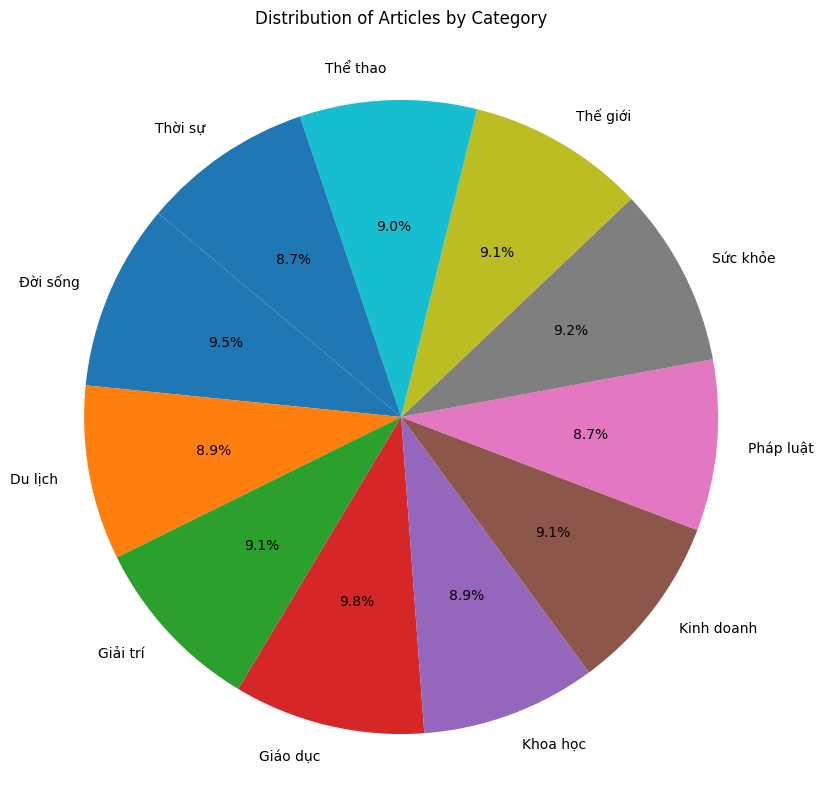

In [9]:
plt.figure(figsize=(9, 10))
plt.pie(categories_dict.values(), labels=categories_dict.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Articles by Category")
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
plt.show()

### Count number of words & characters in each article

In [10]:
df['word_count'] = df['content'].apply(lambda x : len(str(x).split(" ")))
df['char_count'] = df['content'].str.len()                ## This also includes spaces
df[['content', 'word_count', 'char_count']]

,content,word_count,char_count
1,twitter kinh_doanh ra sao sau một năm về tay e...,721,4048
2,thương_mại nga trung gần như_không còn dùng us...,314,1963
3,ngân_hàng nhà_nước khó xử_lý sở_hữu chéo nếu c...,411,2719
4,doanh_nghiệp đào_tạo nhân_viên thành tiktoker ...,531,3606
5,khách hỏi mua hàng việt trên alibaba tăng cao ...,530,3111
...,...,...,...
6762,thanh thảo nhận vé vớt vietnam idol tp hcm tha...,541,3064
6763,loạt tác_phẩm trừu_tượng màu trắng của trần nữ...,696,4225
6764,hà_trí quang mang sổ_đỏ tỷ đồng hỏi cưới đồng ...,386,2104
6765,con_gái xuân_lan diễn loạt show thời_trang bé ...,24,150


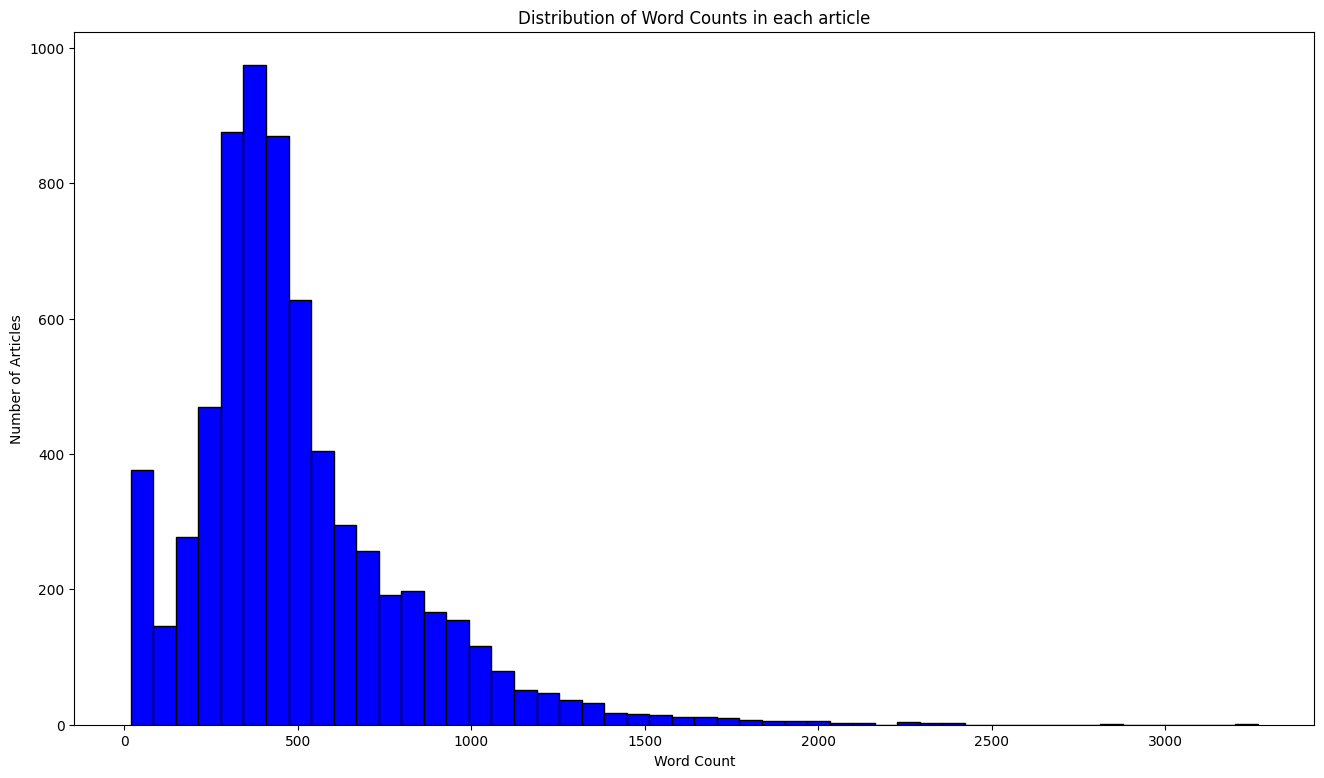

In [11]:
# Histogram: Word counts per article
fig = plt.figure(figsize=(16,9))
plt.hist(df['word_count'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Word Counts in each article')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.show()

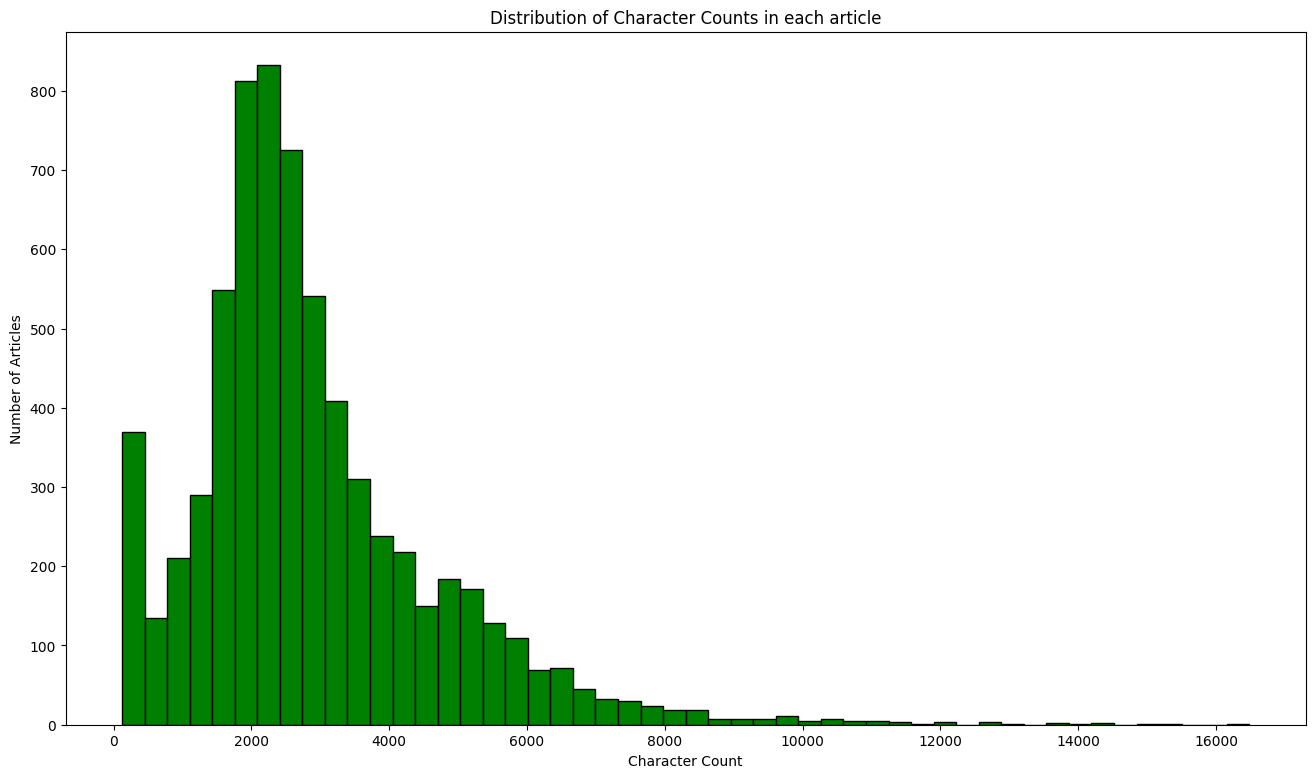

In [12]:
# Histogram: Character counts per article
fig = plt.figure(figsize=(16,9))
plt.hist(df['char_count'], bins=50, color='green', edgecolor='black')
plt.title('Distribution of Character Counts in each article')
plt.xlabel('Character Count')
plt.ylabel('Number of Articles')
plt.show()

### Average Word Length of each article

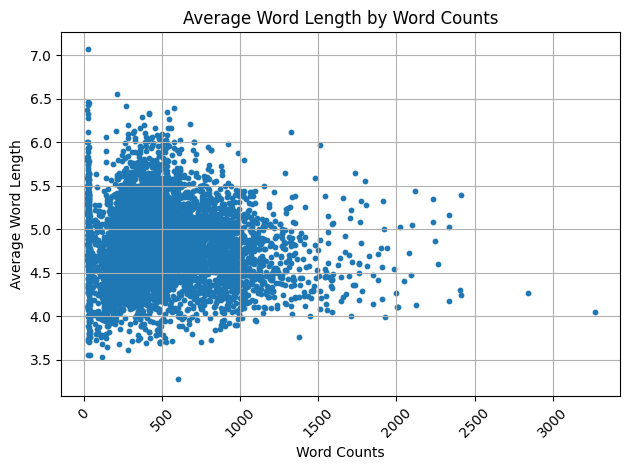

In [13]:
def avg_word(article_content):
    words = article_content.split()    
    return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['content'].apply(lambda x: avg_word(x))
df[['content','avg_word']]

plt.scatter(df['word_count'].to_list(), df['avg_word'].to_list(), marker='o', s=10)
plt.xlabel('Word Counts')
plt.ylabel('Average Word Length')
plt.title('Average Word Length by Word Counts')
plt.xticks(rotation=45)  # Rotate category labels if necessary
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

### Distribution of Stopwords in Articles

#### What is the stopword?
- Stop words are the words in a stop list (or stoplist or negative dictionary) which are filtered out (i.e. stopped) before or after processing of natural language data (text) because they are insignificant.

- We would not want these words to take up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to stop words.

- But, how to find the list of stop words? In this project, we did:
    - Implement calculation IDF for all words in the dataset
    - Extract the word have IDF <= threshold (in our project, we set threshold = 3).
      And we set (minIDF, maxIDF) = (1.0086982995413565, 13.504312537543813)

In [14]:
stop = []
# Open Vietnamese stopwords dictionary
with open("../vietnamese-stopwords/stopwords.txt") as f:
    for line in f:
        stop.append(line)
f.close()

stop = [sample.replace('\n', '') for sample in stop]
stop

['anh',
 'ba',
 'biết',
 'bà',
 'bán',
 'bên',
 'bạn',
 'bắc',
 'bắt_đầu',
 'bằng',
 'bị',
 'bỏ',
 'bộ',
 'bởi',
 'cao',
 'chia_sẻ',
 'chiều',
 'cho',
 'chuyên_gia',
 'chuyển',
 'châu',
 'chính',
 'chúng_tôi',
 'chưa',
 'chương_trình',
 'chỉ',
 'chọn',
 'con',
 'cung_cấp',
 'cuối',
 'cuộc',
 'các',
 'cách',
 'còn',
 'có',
 'có_thể',
 'cô',
 'công_ty',
 'cùng',
 'cũng',
 'cơ_quan',
 'cơ_sở',
 'cả',
 'cấp',
 'cần',
 'của',
 'diễn',
 'do',
 'doanh_nghiệp',
 'dài',
 'dành',
 'dân',
 'dù',
 'dùng',
 'dưới',
 'dẫn',
 'gia_đình',
 'giá',
 'giúp',
 'giảm',
 'giờ',
 'giữ',
 'giữa',
 'gây',
 'gì',
 'gần',
 'gặp',
 'gọi',
 'gồm',
 'hai',
 'hay',
 'hcm',
 'hiện',
 'hoạt_động',
 'hoặc',
 'hà_nội',
 'hàng',
 'hòa',
 'hôm',
 'hơn',
 'hướng',
 'hết',
 'hệ_thống',
 'họ',
 'học',
 'hồi',
 'hỗ_trợ',
 'khi',
 'khiến',
 'khoảng',
 'khu_vực',
 'khác',
 'khách',
 'khó',
 'khó_khăn',
 'không',
 'không_thể',
 'khả_năng',
 'kinh_tế',
 'kết_quả',
 'kể',
 'liên_quan',
 'loại',
 'luôn',
 'là',
 'làm',
 'làm_việc',

In [15]:
print("Total number of different Vietnamese stopwords in our dataset: ", len(stop))

Total number of different Vietnamese stopwords in our dataset:  300


In [17]:
df['stopwords'] = df['content'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['content','stopwords']]

,content,stopwords
1,twitter kinh_doanh ra sao sau một năm về tay e...,454
2,thương_mại nga trung gần như_không còn dùng us...,174
3,ngân_hàng nhà_nước khó xử_lý sở_hữu chéo nếu c...,206
4,doanh_nghiệp đào_tạo nhân_viên thành tiktoker ...,241
5,khách hỏi mua hàng việt trên alibaba tăng cao ...,324
...,...,...
6762,thanh thảo nhận vé vớt vietnam idol tp hcm tha...,259
6763,loạt tác_phẩm trừu_tượng màu trắng của trần nữ...,248
6764,hà_trí quang mang sổ_đỏ tỷ đồng hỏi cưới đồng ...,187
6765,con_gái xuân_lan diễn loạt show thời_trang bé ...,8


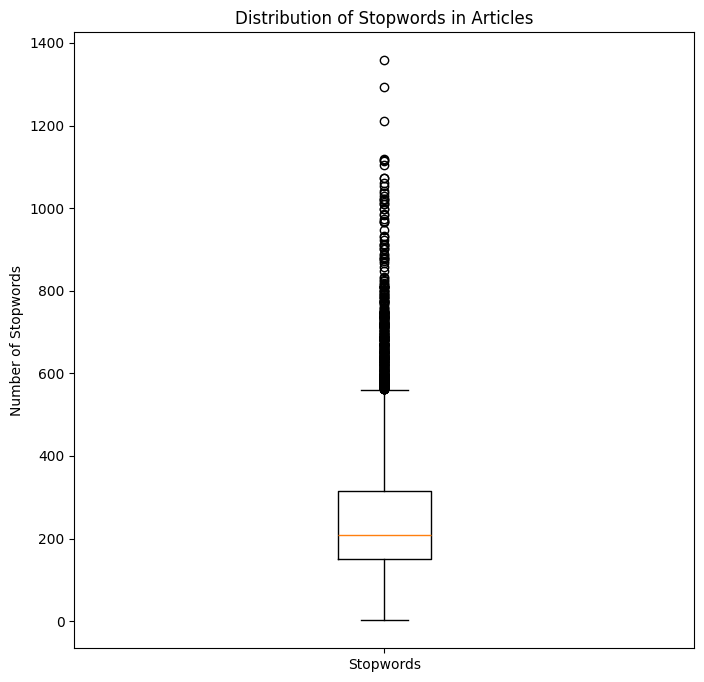

In [18]:
# Boxplot: Distribution of Stopwords in Articles"
plt.figure(figsize=(8, 8))
plt.boxplot(df["stopwords"])
plt.ylabel("Number of Stopwords")
plt.title("Distribution of Stopwords in Articles")
plt.xticks([1], ["Stopwords"])
plt.show()

### Term frequency (TF), Inverse document frequency (IDF), and TF-IDF

In [39]:
# Term frequency:
tfidf = (df['content'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tfidf.columns = ['words', 'tf']

# Inverse document frequency
for i, word in enumerate(tfidf['words']):
    tfidf.loc[i, 'idf'] = np.log(df.shape[0]/(len(df[df['content'].str.contains(word)])))    
tfidf.columns = ['words', 'tf', 'idf']

# Term Frequency – Inverse Document Frequency (TF-IDF)
tfidf['tf-idf'] = tfidf['tf'] * tfidf['idf']

tfidf

/tmp/ipykernel_24609/3940004074.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tfidf = (df['content'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
/tmp/ipykernel_24609/3940004074.py:2: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  tfidf = (df['content'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()


,words,tf,idf,tf-idf
0,nga,13,1.174746,15.271698
1,của,11,0.101329,1.114617
2,trong,8,0.096271,0.770171
3,thương_mại,7,2.666933,18.668529
4,usd,7,1.937228,13.560595
...,...,...,...,...
169,gấp,1,2.493516,2.493516
170,đưa,1,1.044810,1.044810
171,ruble,1,5.293305,5.293305
172,bên,1,1.078566,1.078566


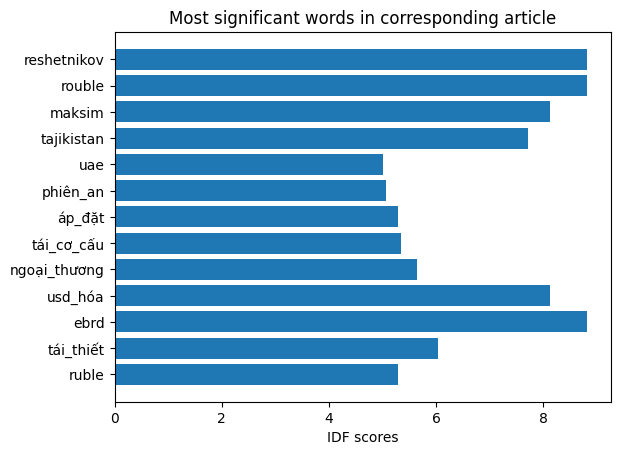

In [47]:
sig_df = tfidf[tfidf['idf'] >= 5]
fig, ax = plt.subplots()

# Example data
words = sig_df['words'].to_list()
y_pos = np.arange(len(words))
idf_score = sig_df['idf'].to_list()

ax.barh(y_pos, idf_score, align='center')
ax.set_yticks(y_pos, labels=words)
ax.invert_yaxis()  
ax.set_xlabel('IDF scores')
ax.set_title('Most significant words in corresponding article')

plt.show()

# 5. Evaluate some classifier in Machine Learning to classify the article

In [48]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## Read raw data

In [49]:
X_train = pickle.load(open('../dataset/processed-data/X_train.pkl', 'rb'))
y_train = pickle.load(open('../dataset/processed-data/y_train.pkl', 'rb'))

X_test = pickle.load(open('../dataset/processed-data/X_test.pkl', 'rb'))
y_test = pickle.load(open('../dataset/processed-data/y_test.pkl', 'rb'))

## Feature Engineering: TF-IDF Vectors as features

In [51]:
# Word level - we choose max number of words equal to 30000 except all words (100k+ words)
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)
tfidf_vect.fit(X_train)
X_train_tfidf = tfidf_vect.transform(X_train)
# Assume that we don't have test set before
X_test_tfidf = tfidf_vect.transform(X_test)

In [50]:
encoder = LabelEncoder()
y_train_n = encoder.fit_transform(y_train)
y_test_n = encoder.fit_transform(y_test)

encoder.classes_

array(['doi-song', 'du-lich', 'giai-tri', 'giao-duc', 'khoa-hoc',
       'kinh-doanh', 'phap-luat', 'suc-khoe', 'the-gioi', 'the-thao',
       'thoi-su'], dtype='<U10')

In [63]:
def train(classifier, X_train, y_train, X_test, y_test, is_neuralnet=False, n_epochs=3):       
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    
    if is_neuralnet:
        classifier.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=512)
        val_predictions = classifier.predict(X_val)
        test_predictions = classifier.predict(X_test)
        val_predictions = val_predictions.argmax(axis=-1)
        test_predictions = test_predictions.argmax(axis=-1)
    else:
        classifier.fit(X_train, y_train)
        train_predictions = classifier.predict(X_train)
        val_predictions = classifier.predict(X_val)
        test_predictions = classifier.predict(X_test)
    
    train_acc = round(accuracy_score(train_predictions, y_train) * 100, 2)
    val_acc = round(accuracy_score(val_predictions, y_val) * 100, 2)
    test_acc = round(accuracy_score(test_predictions, y_test) * 100, 2)

    return train_acc, val_acc, test_acc

## Naive Bayes Classifier
- Multinomal Naive Bayes
- Bernoulli Naive Bayes

In [64]:
train_acc, val_acc, test_acc = train(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("Train accuracy: ", train_acc)
print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Train accuracy:  93.27
Validation accuracy:  89.24
Test accuracy:  87.88


In [69]:
train_acc, val_acc, test_acc = train(BernoulliNB(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("Train accuracy: ", train_acc)
print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Train accuracy:  91.34
Validation accuracy:  86.08
Test accuracy:  84.53


## Linear Classifier
- Logistic Regression

In [65]:
train_acc, val_acc, test_acc = train(LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("Train accuracy: ", train_acc)
print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Train accuracy:  97.04
Validation accuracy:  90.93
Test accuracy:  90.69


## Support Vector Machine (SVM) Classifier

In [66]:
train_acc, val_acc, test_acc = train(SVC(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("Train accuracy: ", train_acc)
print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Train accuracy:  99.62
Validation accuracy:  91.56
Test accuracy:  91.08


## Random Forest Classifier 

In [68]:
train_acc, val_acc, test_acc = train(RandomForestClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("Train accuracy: ", train_acc)
print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Train accuracy:  99.91
Validation accuracy:  92.19
Test accuracy:  89.16


## Gradient Boosting Classifier

In [ ]:
train_acc, val_acc, test_acc = train(GradientBoostingClassifier(), X_train_tfidf, y_train, X_test_tfidf, y_test)
print("Train accuracy: ", train_acc)
print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

<Figure size 1600x900 with 0 Axes>

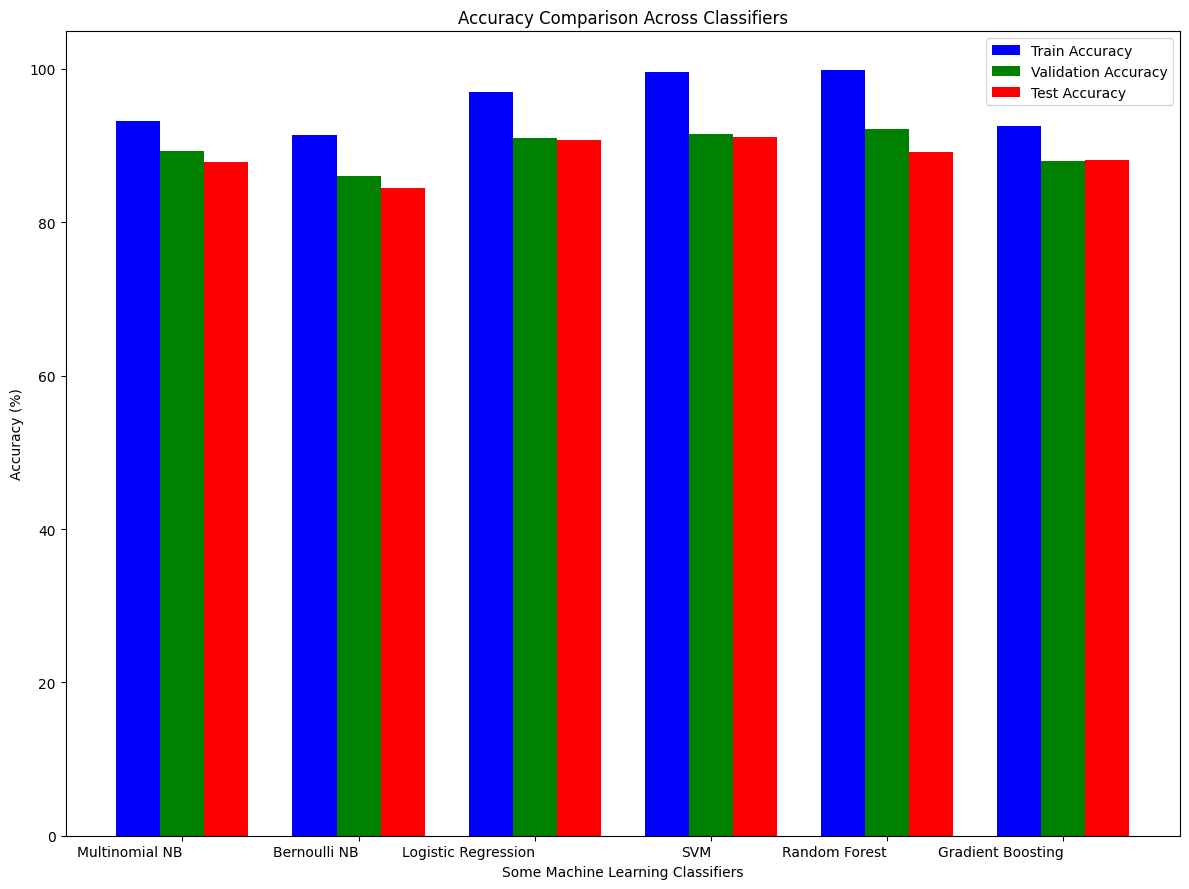

In [91]:
fig = plt.figure(figsize=(16,9))

# Model names
models = ['Multinomial NB', 'Bernoulli NB', 'Logistic Regression', 'SVM', 'Random Forest', 'Gradient Boosting']

# Train accuracies
train_acc = [93.27, 91.34, 97.04, 99.62, 99.91, 92.50]

# Validation accuracies
validation_acc = [89.24, 86.08, 90.93, 91.56, 92.19, 87.94]

# Test accuracies
test_acc = [87.88, 84.53, 90.69, 91.08, 89.16, 88.17]

# Set the bar width
bar_width = 0.25

# X-axis positions for the bars
index = np.arange(len(models))

# Create subplots
fig, ax = plt.subplots(figsize=(12,9))

# Create bars for train, validation, and test accuracies
train_bars = ax.bar(index, train_acc, bar_width, label='Train Accuracy', color='b')
validation_bars = ax.bar(index + bar_width, validation_acc, bar_width, label='Validation Accuracy', color='g')
test_bars = ax.bar(index + 2 * bar_width, test_acc, bar_width, label='Test Accuracy', color='r')

# Set the labels, title, and legend
ax.set_xlabel('Some Machine Learning Classifiers')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy Comparison Across Classifiers')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(models, rotation=0, ha='right')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
